In [1]:
%%html
<link href="https://fonts.googleapis.com/css2?family=Alegreya&family=Cinzel&display=swap" rel="stylesheet">
<style>
    .text_cell_render {
    font-family: 'Alegreya', serif;
    font-size: 12pt;
    }
</style>

# Assignment 2

> Group Members: Julius Kappenberg, Alexandros Gilch, Paul Grass, Tim Mensinger, Philipp Schirmer

We suggest reading this notebook [online](https://nbviewer.jupyter.org/github/timmens/macro_problems/blob/main/assignment2.ipynb?flush_cache=False) for the best reading experience.

## Question I: Monetary Policy

The Stata code which was used to compile the results of question 1 is appended at the end of this document.

### i.

When correlating the constructed instrument with the short term interest rates, we find a correlation of about 0.317. This correlation is moderately positive and suggests that we can reject the hypothesis of instrument irrelevance.
Figure 1 confirms this finding and provides a graphical intuition of the correlation as influential values do not seem to affect the correlation coefficient significantly. Unsurprisingly, there are many values where the instrument is 0, which correspond to floating exchange rate regimes.


<figure>

<img src="figures/figure1.png" alt="Trulli" style="width:100%">
<figcaption style="text-align:center; font-size:10pt">
    <i>
        Figure 1: Scatterplot of the short term interest rate and the instrument z, with fit.
    </i>
</figcaption>
    
</figure>


### ii.

In order to estimate the effect of a change in the short-term interest rate as instrumented by z, we require some set-up. Working with the Jordà Schularick Taylor (2020) data set, we use the changes in real GDP, consumer price index, credit to GDP ratio and real stock prices over a time horizon of four years (periods) after an interest rate shock in the base country as dependent variables.
In the second step, for each time horizon length of one to four periods, we run an instrumental variable regression and include the control variables described in the task. From each of the total of 16 regressions, we save the estimated coefficient of an (instrumented) short term interest rate increase of 100 basis points (i.e., one percentage point) on (i) real GDP per capita, (ii) the consumer price index (CPI), (iii) the credit to GDP ratio, and (iv) real stock prices, respectively.


<figure>

<img src="figures/figure2.png" alt="Trulli" style="width:100%">
<figcaption style="text-align:center; font-size:10pt">
    <i>
        Figure 2: Response of macroeconomic variables  of an 100 basis point increase of short term interest rate, 1SE and 90% confidence bands.
    </i>
</figcaption>
    
</figure>



Figure 2 depicts the four response plots for each dependent variable with the confidence bands  (grey shaded areas). The effect of an interest rate increase varies widely, both in magnitude and variability of the estimates. In line with standard economic theory, we find a significant and negative effect of an interest rate shock on real GDP that starts immediately after the shock and amplifies over the subsequent 4 years. On average, GDP drops by -1% one year after the shock to about -2% after four years. The response of the consumer price index is insignificant over the first two years after an interest rate increase in the base country, but turns significantly negative three years after the shock and reaches -3% after four years. Similarly, the credit to GDP ratio remains unaffected in the first two periods, but point estimates indicate a drop by about -1.5% and -2% in the third and fourth year after the shock. However, none of these estimates are statistically significant. While the potential magnitude of the response of real stock prices is strong, it is the only dependent variable that does not exhibit a monotonous response. In the first period after the increase, prices drop by a statistically significant -5%, but estimates for years 2 and 3 after the shock are insignificant. In the fourth period after the shock, stock prices drop significantly, on average by about -10%. The parameter estimates  we obtain are qualitatively in line with Jordà, Schularick and Taylor (2017) and often coincide in quantitative terms.



### iii.

Part iii) discusses the impact of US monetary policy on macroeconomic variables in other countries in the world. Instead of instrumenting the local short term interest rate, we hence consider how an increase in the US short term interest rate impacts real GDP and international real stock prices globally.

If we consider interest rate shocks in the US to be exogenous from macroeconomic factors in the rest of the world, we can estimate the causal effect of the Fed's monetary policy on real economic outcomes in the rest of the world. Since the US has a free floating currency, we cannot use our instrument that exploits changes in base country interest rates for fixed exchange rate regimes. Instead, we run an OLS regression that accounts for the set of control variables and their lags as in ii). Importantly, this simplistic approach cannot be applied to evaluate monetary policy in the US itself, as there might be a strong endogeneity between macroeconomic variables and monetary policy. 


<figure>

<img src="figures/figure3.png" alt="Trulli" style="width:100%">
<figcaption style="text-align:center; font-size:10pt">
    <i>
        Figure 3: Response of international real GDP per capita and stock price to a 100 basis points increase in the US short term interest rate with 1SE (dark grey) and 90% (light grey) confidence bands.
    </i>
</figcaption>
    
</figure>


Figure 3 depicts the percentage response of a one percentage point (100 basis point) increase in US short term interest rate on i) global real GDP and ii) global real stock prices. 
Both macroeconomic variables appear to be negatively affected. Global real GDP decreases over the four year horizon by roughly 0.15 percent per year, amounting to a statistically significant decrease of about -0.6% after four years. Similarly, on impact, global real stock prices are negatively affected by an increase in US short term interest rate; in the first two years after the change, stock prices decrease by a statistically insignificant 0.5 percent, but they significantly fall in the third and fourth year for a total of -2%. Hence, if the identifying assumptions hold and we can interpret the estimates causally, the monetary policy of the US has a relatively strong impact on global macroeconomic outcomes. In particular, a monetary tightening would significantly lower GDP growth and stock prices in the rest of the world.

However, the importance of macroeconomic interlinkages and spillover effects casts doubt about whether the identifying assumption holds. While US monetary policy is mainly influenced by domestic macroeconomic conditions, other countries, the global macroeconomic environment broadly and the outlook and policies of important trade partners in particular likely affects the Fed’s monetary policy. 


### iv.

Estimating the effect of US monetary policy on domestic economic outcomes makes the endogeneity issue even more salient: arguably, the Fed devises its monetary policy based on the domestic economic outlook, hence causality likely goes in both ways. To account for the endogeneity, we utilize the narratively identified shock measure of Romer and Romer (2004) as plausibly exogenous monetary policy shocks.

<figure>

<img src="figures/figure4.png" alt="Trulli" style="width:100%">
<figcaption style="text-align:center; font-size:10pt">
    <i>
        Figure 4: Percentage response of US real GDP per capita and consumer price index (CPI) to a 1 percentage point increase in the US short term interest rate. Reported are 1SE (dark grey) and 90% (light grey) confidence bounds
    </i>
</figcaption>
    
</figure>


Figure 4 depicts our results for iv.1 and iv.2. The panel on the left suggests a very noisy and statistically insignificant effect on the real GDP. Estimates range between +0.2% after two years to -0.5% percent after four years, neither of which are statistically significant. For the consumer price index, however, we find statistically as well as economically significant negative estimates three and four years after the shock. In line with economic theory, consumer prices respond to a 1 percentage point increase in the short term interest rate by a significant drop in prices of about -3 percent and -4 percent after three and four years, respectively. 


<figure>

<img src="figures/figure5.png" alt="Trulli" style="width:100%">
<figcaption style="text-align:center; font-size:10pt">
    <i>
        Figure 5: Percentage response of US real GDP per capita and consumer price index (CPI) to a 1 percentage point increase in the US short term interest rate. Reported are 1SE (dark grey) and 90% (light grey) confidence bounds, split sample pre and post 1985.
    </i>
</figcaption>
    
</figure>

Figure 5 reports our findings for a split sample pre-1985 and post-1985. We find no statistically significant effect of monetary policy on real GDP in either subsample. Before 1985, point estimates range between -1% after one year to -1.5% after three years, before recovering again entirely in the fourth year after the policy shock. Post-1985, the estimated effect is positive, but very close to zero with a statistically insignificant effect of about +0.5%. However, due to the small number of observations (the Romer and Romer shock measure is only available from 1969 onwards and the specification uses four lags), the pre-1985 estimates need to be treated with particular caution. 

Again, given the small number of observations, the evidence on price effects of monetary policy in the period before 1985 remain inconclusive. The top-right panel suggests that there is no statistically significant effect in the first two years after the shock, but a very pronounced deflationary effect of more the 5% in the third and fourth year after the shock. This contrasts with the estimated effect in the post-1985 sample, where if anything, we find a marginally significant positive effect of monetary tightening on prices about two years later. The split sample suggests that the negative effect on the prices in the full sample is driven mostly by the earlier period, while there is no pronounced effect in the post 1985 period.

## Question II: Fiscal Policy

This part of the notebook is structured as follows: First we define functions that implement the local projection method, the plotting of the resulting impulse response functions and the data preparation step. This section can be skipped. Aferwards, in the results section, we answer question *i.* Then we apply the local projection method on our data and plot the impulse response functions. At last we summarize our findings and answer question *iii.*

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import scipy as sp

sns.set_style("whitegrid")

## Code

#### Local Projection Method

In [3]:
def _create_formula_with_lags(var_name, n_lags):
    """Creates formula str of var_name with n_lags."""
    covariates = [f"{var_name}.shift({i})" for i in range(1, n_lags + 1)]
    formula = " + ".join(covariates)
    return formula


def _create_formula_to_extract_shocks(endog, exog, n_lags):
    """Creates callable formula str with lagged exog regressors."""
    exog_formulas = [_create_formula_with_lags(name, n_lags) for name in exog]
    formula = f"{endog} ~ 1 + " + " + ".join(exog_formulas)
    return formula


def local_projection(df, n_response_periods, n_lags, alpha):
    """Estimate impulse response using local projections.
    
    This function is not written in a general manner and this is
    on purpose. Sets of exogeneous and endogeneous variables are
    defined inside to avoid overly abstract code.
    
    Args:
        df (pandas.DataFrame): The data.
        n_response_periods (int): Number of response periods.
        n_lags (int): Number of lags to use in shock creation.
        alpha (float): Confidence level. Must be in [0, 1].
        
    Returns:
        Dict[pandas.DataFrame]: Dictionary containing
            impulse_response: The estimated impulse responses.
            df: The updated initial data frame.
    
    """
    exog = ["g_pc", "gdp_pc", "rev_pc"]
    exog_formulas = [_create_formula_with_lags(name, n_lags) for name in exog]
    exog_formula = " + ".join(exog_formulas)

    # estimate impulse responses
    impulse_response = pd.DataFrame(columns=["h", "endog", "estimate", "se"])
    impulse_response = impulse_response.set_index(["h", "endog"])

    for h in range(n_response_periods):
        for endog in df.columns:
            formula = f"{endog}.shift({-h-1}) ~ 1 + g_pc + " + exog_formula
            model = sm.ols(formula, df).fit(cov_type="HAC", cov_kwds={"maxlags": 1})
            theta = model.params["g_pc"]
            theta_se = model.bse["g_pc"]
            impulse_response.loc[(h + 1, endog), "estimate"] = theta
            impulse_response.loc[(h + 1, endog), "se"] = theta_se

    # result processing
    cf = sp.stats.norm.ppf(1 - alpha / 2)  # confidence factor
    impulse_response = impulse_response.reset_index().convert_dtypes()
    impulse_response.estimate *= -1
    impulse_response = impulse_response.assign(
        **{
            "lower_ci": impulse_response.estimate - cf * impulse_response.se,
            "upper_ci": impulse_response.estimate + cf * impulse_response.se,
        }
    )

    result = {"impulse_response": impulse_response, "df": df}
    return result

#### Impulse Response Plot

In [4]:
def plot_impulse_responses(result, df):
    """Plots all impulse responses."""
    fig, axes = plt.subplots(4, 2)
    fig.set_size_inches(17, 20)

    for ax, col in zip(axes.flatten(), df.columns):

        # subset data
        _data = (
            result["impulse_response"]
            .query("endog == @col")
            .drop(columns="endog")
            .astype(float)
        )

        # plot estimate
        p = sns.lineplot(x="h", y="estimate", data=_data, ax=ax, label=col)

        # plot standard errors
        ax.plot(_data["h"], _data["lower_ci"], alpha=0.3, color="tab:blue")
        ax.plot(_data["h"], _data["upper_ci"], alpha=0.3, color="tab:blue")
        ax.fill_between(
            _data["h"],
            _data["lower_ci"],
            _data["upper_ci"],
            alpha=0.2,
            color="tab:blue",
        )

        # adjust plot
        ax.axhline(0, color="black", alpha=0.85, zorder=-1)
        ax.xaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_tick_params(labelsize=14)
        ax.set(ylabel="IR", xlabel=r"$h$")
        ax.set_frame_on(False)
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        _ = ax.legend(frameon=False, fontsize=14)

    # mark relevant variables
    rect = plt.Rectangle(
        # (lower-left corner), width, height
        (0.073, 0.687),
        0.415,
        0.2,
        fill=False,
        color="tab:red",
        lw=2,
        zorder=1000,
        transform=fig.transFigure,
        figure=fig,
    )
    fig.patches.extend([rect])
    return None

#### Data Reading and Cleaning

In [5]:
def _log_transform(column, ignore=None):
    column = column.copy()
    ignore = ignore if isinstance(ignore, list) else [ignore]
    if column.name not in ignore:
        column = 100 * np.log(column)
    return column


def read_and_clean_data():
    """Read and prepare data."""
    df = pd.read_stata("data/fiscal_data1930s.dta")
    df = df.set_index("date")
    df = df.transform(_log_transform, ignore="irate")
    return df

## Results
 
### i.
From the question description we recall
 
 > The identifying assumption is that public expenditures are predetermined within a given period (i.e., they do not react to shocks to other variables in the same time period).
 
The below output table shows the time difference between consecutive periods in days. From this table we can be sure that the data contains monthly observations. One may then argue that during the period of a full month, shocks can occur to other variables to which the political process can respond with a change in the same period. However, since the political process is known to be slow, the assumption that such a response takes _at least a month_ does seem reasonable. Even in (economic) crises, bureaucracy may not allow for responses to be significantly faster than a month. To understand the actual severity of this assumption we would have to study the efficiency with which political decisions were taking place during the observed time span.

In [6]:
df = read_and_clean_data()

In [7]:
diff = np.diff(df.index).astype("timedelta64[D]")
diff = pd.Series(diff).dt.days
diff.value_counts().to_frame("n_obs").rename_axis(index="days").T

days,31,30,28,29
n_obs,55,32,5,2


### ii.

#### Application of Local Projection Method

Next we call our implemented local projection method with the desired parameter values. We further set the confidence level to 95% using ``alpha=0.05``. 

In [8]:
result = local_projection(df, n_response_periods=24, n_lags=6, alpha=0.05)

#### Plotting

The figure below shows the impulse response functions for all columns of the data set. The impulse response function for GDP is highlighted by the red frame.

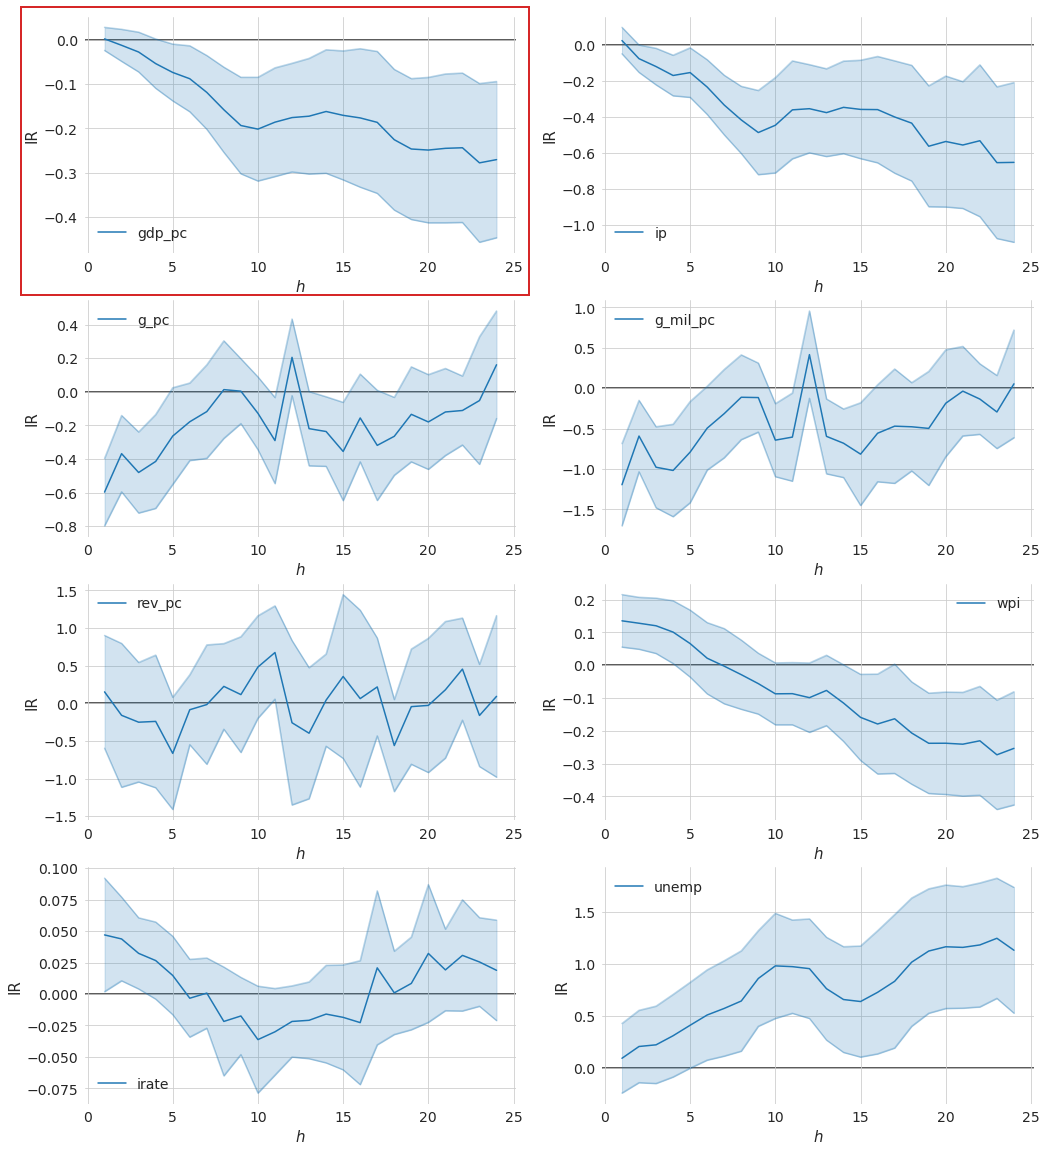

In [9]:
plot_impulse_responses(result, df)

### iii.

Our estimates show a negative effect of a decrease in government spendings on GDP. The effect manifests fully after 10 months and amounts to -0,2 to -0,25 percentage points. This supports the argument that Brüning’s austerity policy was detrimental for the German economy at the time. However, the estimate for the loss of GDP after a budget spending shock is too small to advocate for this policy to be a main reason for the output slump. Brüning’s policy contributed to the negative effect but could not have avoided it by increasing government spending.

## Appendix

### Stata Code for Question 1

```Stata
* Assignment 2 *********

* Exercise 1: The effects of monetary policy
clear
set more off

* change graph schemes
set scheme s1color
graph set window fontface "Palatino Linotype"
graph drop _all

* Set working directory
* local path "/Users/paulgrass/OneDrive/Documents/BGSE Semester 2/Macroeconomics II/Stata"

local path "/Users/Philipp/OneDrive/Master Economic Research/Macro II/PS2 Schularick/Assignment2_2021"


cd "`path'"

use "JSTdataset.dta"

*******
* sort out panel structure, drop 2014 - 2015 observations
drop if mi(country)
xtset, clear
xtset ifs year

* gen variables and transformations of them used *****************
* real inv per capita , real house / stock prices :
gen riypc = iy * rgdppc
gen hpreal = hpnom / cpi
gen rstocks = stocks / cpi

* first diff of log:

foreach var of varlist rgdppc rconpc riypc cpi hpreal rstocks {
	gen l_`var' = log(`var')
	gen dl_`var' = d.l_`var'
}

* first diff of credit to GDP , short / long term rate
gen credittogdp = tloans / gdp
gen d_credit = d.credittogdp
gen d_stir = d.stir
gen d_ltrate = d.ltrate

* world GDP growth
gen rgdp = rgdppc *pop
sort year
by year: egen rgdp_wld = total(rgdp)
xtset ifs year
gen gr_rgdp_wld = d.rgdp_wld / l.rgdp_wld
gen d_gr_rgdp_wld = d.gr_rgdp_wld

**********************************************

rename openquinn kaopen
replace kaopen = kaopen / 100

* create instrument

gen z = dibaseF * peg * l.peg * kaopen

* remove world wars
drop if year > 1938 & year < 1948
drop if year > 1913 & year < 1920


* (i) *******************************************************

* scatter with correlation
* calculate here

corr d_stir z
local corr : di %5.3g r(rho)

* use as subtitle in scatter
twoway scatter d_stir z || lfit d_stir z , subtitle(correlation `corr')
xtreg d_stir z, fe
graph export "i.pdf", as(pdf) replace
graph export "i.png", as(png) replace


* (ii) ******************************************************

* prelims

local L = 2
local H = 4

forvalues h = 0/`H' {
	gen fgdp`h' = f`h'.rgdppc / l.rgdppc - 1
	gen fcpi`h' = f`h'.cpi / l.cpi - 1
	gen fcredit`h' = f`h'.credittogdp / l.credittogdp - 1
	gen fstocks`h' = f`h'.rstocks / l.rstocks - 1
}

matrix irf_gdp = J(`H'+1,1,0)
matrix irf_gdp_lb = irf_gdp
matrix irf_gdp_2lb = irf_gdp
matrix irf_gdp_ub = irf_gdp
matrix irf_gdp_2ub = irf_gdp

matrix irf_cpi = irf_gdp
matrix irf_cpi_lb = irf_gdp
matrix irf_cpi_2lb = irf_gdp
matrix irf_cpi_ub = irf_gdp
matrix irf_cpi_2ub = irf_gdp

matrix irf_credit = J(`H'+1,1,0)
matrix irf_credit_lb = irf_gdp
matrix irf_credit_2lb = irf_gdp
matrix irf_credit_ub = irf_gdp
matrix irf_credit_2ub = irf_gdp


matrix irf_stocks = irf_gdp
matrix irf_stocks_lb = irf_gdp
matrix irf_stocks_2lb = irf_gdp
matrix irf_stocks_ub = irf_gdp
matrix irf_stocks_2ub = irf_gdp



forvalues h = 0 / `H' {
	
	* GDP

	xtivreg fgdp`h' l(0/`L').(dl_rgdppc dl_rconpc dl_riypc ///
		dl_cpi d_ltrate dl_hpreal dl_rstocks d_credit d_gr_ ///
		rgdp_wld ) l(1/`L').d_stir (d_stir = z), fe vce(r)
	
	matrix irf_gdp[`h'+1,1] = _b[d_stir]
	matrix irf_gdp_lb[`h'+1,1] = _b[d_stir] - _se[d_stir]
	matrix irf_gdp_ub[`h'+1,1] = _b[d_stir] + _se[d_stir]
	matrix irf_gdp_2lb[`h'+1,1] = _b[d_stir] - 1.64 * _se[d_stir]
	matrix irf_gdp_2ub[`h'+1,1] = _b[d_stir] + 1.64 * _se[d_stir]


	* prices

	xtivreg fcpi`h' l(0/`L').(dl_rgdppc dl_rconpc dl_riypc ///
		dl_cpi d_ltrate dl_hpreal dl_rstocks d_credit d_gr_ ///
		rgdp_wld ) l(1/`L').d_stir (d_stir = z), fe vce(r)
		
	matrix irf_cpi[`h'+1,1] = _b[d_stir]
	matrix irf_cpi_lb[`h'+1,1] = _b[d_stir] - _se[d_stir]
	matrix irf_cpi_ub[`h'+1,1] = _b[d_stir] + _se[d_stir]
	matrix irf_cpi_2lb[`h'+1,1] = _b[d_stir] - 1.64 * _se[d_stir]
	matrix irf_cpi_2ub[`h'+1,1] = _b[d_stir] + 1.64 * _se[d_stir]
	
	* credit
	xtivreg fcredit`h' l(0/`L').(dl_rgdppc dl_rconpc dl_riypc ///
		dl_cpi d_ltrate dl_hpreal dl_rstocks d_credit d_gr_rgdp_wld) ///
		l(1/`L').d_stir (d_stir = z), fe vce(r)
	matrix irf_credit[`h'+1,1] = _b[d_stir]
	matrix irf_credit_lb[`h'+1,1] = _b[d_stir] - _se[d_stir]
	matrix irf_credit_ub[`h'+1,1] = _b[d_stir] + _se[d_stir]
	matrix irf_credit_2lb[`h'+1,1] = _b[d_stir] - 1.64 * _se[d_stir]
	matrix irf_credit_2ub[`h'+1,1] = _b[d_stir] + 1.64 * _se[d_stir]
	
	* stock prices
	xtivreg fstocks`h' l(0/`L').(dl_rgdppc dl_rconpc dl_riypc ///
		dl_cpi d_ltrate dl_hpreal dl_rstocks d_credit d_gr_rgdp_wld) ///
		l(1/`L').d_stir (d_stir = z), fe vce(r)
	matrix irf_stocks[`h'+1,1] = _b[d_stir]
	matrix irf_stocks_lb[`h'+1,1] = _b[d_stir] - _se[d_stir]
	matrix irf_stocks_ub[`h'+1,1] = _b[d_stir] + _se[d_stir]
	matrix irf_stocks_2lb[`h'+1,1] = _b[d_stir] - 1.64 * _se[d_stir]
	matrix irf_stocks_2ub[`h'+1,1] = _b[d_stir] + 1.64 * _se[d_stir]
}

svmat irf_gdp, names(irf_gdp)
svmat irf_gdp_lb, names(irf_gdp_lb)
svmat irf_gdp_ub, names(irf_gdp_ub)
svmat irf_gdp_2lb, names(irf_gdp_2lb)
svmat irf_gdp_2ub, names(irf_gdp_2ub)
svmat irf_cpi, names(irf_cpi)
svmat irf_cpi_lb, names(irf_cpi_lb)
svmat irf_cpi_ub, names(irf_cpi_ub)
svmat irf_cpi_2lb, names(irf_cpi_2lb)
svmat irf_cpi_2ub, names(irf_cpi_2ub)
svmat irf_credit, names(irf_credit)
svmat irf_credit_lb, names(irf_credit_lb)
svmat irf_credit_ub, names(irf_credit_ub)
svmat irf_credit_2lb, names(irf_credit_2lb)
svmat irf_credit_2ub, names(irf_credit_2ub)
svmat irf_stocks , names(irf_stocks)
svmat irf_stocks_lb , names(irf_stocks_lb)
svmat irf_stocks_ub , names(irf_stocks_ub)
svmat irf_stocks_2lb , names(irf_stocks_2lb)
svmat irf_stocks_2ub , names(irf_stocks_2ub)

* plots

gen horizon = _n-1 if _n <= `H'+1
gen zeros = 0 if horizon !=.

foreach var of varlist irf_gdp1 - irf_stocks_2ub1 {
	replace `var' = 100 * `var'
}

* IRF of gdp, cpi, credit, stocks to local interest rate change
	
twoway (rarea irf_gdp_2lb1 irf_gdp_2ub1 horizon, color(gs15)) ///
	(rarea irf_gdp_lb1 irf_gdp_ub1 horizon, color(gs13)) ///
	(line irf_gdp1 horizon, color(blue)) ///
	(line zeros horizon, color(black)), ///
	legend(off) title("real GDP per capita") xtitle("year") ytitle("response in percent") ///
	name(ii_gdp, replace) nodraw	
	
twoway (rarea irf_cpi_2lb1 irf_cpi_2ub1 horizon, color(gs15)) ///
	(rarea irf_cpi_lb1 irf_cpi_ub1 horizon, color(gs13)) ///
	(line irf_cpi1 horizon, color(blue)) ///
	(line zeros horizon, color(black)), ///
	legend(off) title("CPI") xtitle("year") ytitle("response in percent") ///
	name(ii_cpi, replace) nodraw
	
twoway (rarea irf_credit_2lb1 irf_credit_2ub1 horizon, color(gs15)) ///
	(rarea irf_credit_lb1 irf_credit_ub1 horizon, color(gs13)) ///
	(line irf_credit1 horizon, color(blue)) ///
	(line zeros horizon, color(black)), ///
	legend(off) title("Credit to GDP") xtitle("year") ytitle("response in percent") ///
	name(ii_credit, replace) nodraw
	
twoway (rarea irf_stocks_2lb1 irf_stocks_2ub1 horizon, color(gs15)) ///
	(rarea irf_stocks_lb1 irf_stocks_ub1 horizon, color(gs13)) ///
	(line irf_stocks1 horizon, color(blue)) ///
	(line zeros horizon, color(black)), ///
	legend(off) title("real stock prices") xtitle("year") ytitle("response in percent") ///
	name(ii_stocks, replace) nodraw
	
graph combine ii_gdp ii_cpi ii_credit ii_stocks, ///
	name(combined_ii, replace)
	
graph export "ii.pdf", as(pdf) replace
graph export "ii.png", as(png) replace

* (iii) ****************************************************************************
* use OLS, IV doesn't make sense since there is no base country for US

* generate US interest rate for all observations

local H=4

gen usa_i = stir if country == "USA"
bysort year(usa_i) : replace usa_i = usa_i[1]
xtset ifs year
gen d_usa_i = d.usa_i

matrix irf_gdpus = J(`H'+1,1,0)
matrix irf_gdpus_lb = irf_gdpus
matrix irf_gdpus_ub = irf_gdpus
matrix irf_gdpus_2lb = irf_gdpus
matrix irf_gdpus_2ub = irf_gdpus
matrix irf_stocksus = irf_gdpus
matrix irf_stocksus_lb = irf_gdpus
matrix irf_stocksus_ub = irf_gdpus
matrix irf_stocksus_2lb = irf_gdpus
matrix irf_stocksus_2ub = irf_gdpus

forvalues h= 0/`H'{
	
	* GDP
	xtreg fgdp`h' d_usa_i l(0/`L').(dl_rgdppc dl_rconpc dl_riypc ///
		dl_cpi d_ltrate dl_hpreal dl_rstocks d_credit ///
		d_gr_rgdp_wld) l(1/`L').d_stir, fe

	matrix irf_gdpus[`h'+1,1] = _b[d_usa_i]
	matrix irf_gdpus_lb[`h'+1,1] = _b[d_usa_i] - _se[d_usa_i]
	matrix irf_gdpus_ub[`h'+1,1] = _b[d_usa_i] + _se[d_usa_i]
	matrix irf_gdpus_2lb[`h'+1,1] = _b[d_usa_i] - 1.64 * _se[d_usa_i]
	matrix irf_gdpus_2ub[`h'+1,1] = _b[d_usa_i] + 1.64 * _se[d_usa_i]
	
	* stock prices
	xtreg fstocks`h' d_usa_i l(0/`L').(dl_rgdppc dl_rconpc dl_riypc ///
		dl_cpi d_stir d_ltrate dl_hpreal dl_rstocks ///
		d_credit d_gr_rgdp_wld ) l(1/`L').d_stir, fe
	matrix irf_stocksus[`h'+1,1] = _b[d_usa _i ]
	matrix irf_stocksus_lb[`h'+1,1] = _b[d_usa_i] - _se[d_usa_i]
	matrix irf_stocksus_ub[`h'+1,1] = _b[d_usa_i] + _se[d_usa_i]
	matrix irf_stocksus_2lb[`h'+1,1] = _b[d_usa_i] - 1.64 * _se[d_usa_i]
	matrix irf_stocksus_2ub[`h'+1,1] = _b[d_usa_i] + 1.64 * _se[d_usa_i]
}

svmat irf_gdpus, names(irf_gdpus)
svmat irf_gdpus_lb, names(irf_gdpus_lb)
svmat irf_gdpus_ub, names(irf_gdpus_ub)
svmat irf_gdpus_2lb, names(irf_gdpus_2lb)
svmat irf_gdpus_2ub, names(irf_gdpus_2ub)
svmat irf_stocksus, names(irf_stocksus)
svmat irf_stocksus_lb, names(irf_stocksus_lb)
svmat irf_stocksus_ub, names(irf_stocksus_ub)
svmat irf_stocksus_2lb, names(irf_stocksus_2lb)
svmat irf_stocksus_2ub, names(irf_stocksus_2ub)

foreach var of varlist irf_gdpus1 - irf_stocksus_2ub1 {
	replace `var' = 100 * `var'
}

twoway (rarea irf_gdpus_2lb1 irf_gdpus_2ub1 horizon, color(gs15)) ///
	(rarea irf_gdpus_lb1 irf_gdpus_ub1 horizon, color(gs13)) ///
	(line irf_gdpus1 horizon, color(blue)) ///
	(line zeros horizon, color(black)), ///
	legend(off) title("real GDP") xtitle("year") ytitle("response in percent") ///
	name(iii_gdp, replace) nodraw
	
twoway (rarea irf_stocksus_2lb1 irf_stocksus_2ub1 horizon, color(gs15)) ///
	(rarea irf_stocksus_lb1 irf_stocksus_ub1 horizon, color(gs13)) ///
	(line irf_stocksus1 horizon, color(blue)) ///
	(line zeros horizon, color(black)), ///
	legend(off) title("real stock prices") xtitle("year") ytitle("response in percent") ///
	name(iii_stocks, replace) nodraw

graph combine iii_gdp iii_stocks, name(combined_iii, replace )
graph export "iii.pdf", as(pdf) replace
graph export "iii.png", as(png) replace

* (iv) ***********************************************************************************

keep if country == "USA" & year >= 1969 & year <= 2007
* tsset year


local L = 4
local H = 4


matrix irf_gdprr = J(`H'+1,1,0)
matrix irf_gdprr_lb = irf_gdprr
matrix irf_gdprr_ub = irf_gdprr
matrix irf_gdprr_2lb = irf_gdprr
matrix irf_gdprr_2ub = irf_gdprr

matrix irf_cpirr = irf_gdprr
matrix irf_cpirr_lb = irf_gdprr
matrix irf_cpirr_ub = irf_gdprr
matrix irf_cpirr_2lb = irf_gdprr
matrix irf_cpirr_2ub = irf_gdprr



forvalues h = 0/`H'{
	
	*GDP
	newey fgdp`h' annualized_RRextended_shock dl_rgdppc l(1/`L').(annualized_RRextended_shock dl_rgdppc), lag(`h')

	newey fgdp`h' annualized_RRextended_shock dl_rgdppc l(1/`L').(annualized_RRextended_shock dl_rgdppc), lag(`h')
	matrix irf_gdprr[`h'+1,1] = _b[annualized_RRextended_shock]
	matrix irf_gdprr_lb[`h'+1,1] = _b[annualized_RRextended_shock] - _se[annualized_RRextended_shock]
	matrix irf_gdprr_ub[`h'+1,1] = _b[annualized_RRextended_shock] + _se[annualized_RRextended_shock]
	matrix irf_gdprr_2lb[`h'+1,1] = _b[annualized_RRextended_shock] - 1.64 * _se[annualized_RRextended_shock]
	matrix irf_gdprr_2ub[`h'+1,1] = _b[annualized_RRextended_shock] + 1.64 * _se[annualized_RRextended_shock]

	* prices
	newey fcpi`h' annualized_RRextended_shock dl_cpi l(1/`L').(annualized_RRextended_shock dl_cpi), lag(`h')
	matrix irf_cpirr[`h'+1,1] = _b[annualized_RRextended_shock]
	matrix irf_cpirr_lb[`h'+1,1] = _b[annualized_RRextended_shock] - _se[annualized_RRextended_shock]
	matrix irf_cpirr_ub[`h'+1,1] = _b[annualized_RRextended_shock] + _se[annualized_RRextended_shock]
	matrix irf_cpirr_2lb[`h'+1,1] = _b[annualized_RRextended_shock] - 1.64 * _se[annualized_RRextended_shock]
	matrix irf_cpirr_2ub[`h'+1,1] = _b[annualized_RRextended_shock] + 1.64 * _se[annualized_RRextended_shock]
} 

svmat irf_gdprr, names(irf_gdprr1)
svmat irf_gdprr_lb, names(irf_gdprr_lb)
svmat irf_gdprr_ub, names(irf_gdprr_ub)
svmat irf_gdprr_2lb, names(irf_gdprr_2lb)
svmat irf_gdprr_2ub, names(irf_gdprr_2ub)
svmat irf_cpirr, names(irf_cpirr)
svmat irf_cpirr_lb, names(irf_cpirr_lb)
svmat irf_cpirr_ub, names(irf_cpirr_ub)
svmat irf_cpirr_2lb, names(irf_cpirr_2lb)
svmat irf_cpirr_2ub, names(irf_cpirr_2ub)

foreach var of varlist irf_gdprr1 - irf_cpirr_2ub1 {
	replace `var' = 100 * `var'
}

* IRF of gdp , cpi , to RR shock


/*
gen horizon_trick=year-1969
replace horizon_trick=. if horizon_trick>=5
*/

local H=4

drop horizon
gen horizon = _n-1 if _n <= `H'+1
drop zeros
gen zeros = 0 if horizon !=.


twoway (rarea irf_gdprr_2lb1 irf_gdprr_2ub1 horizon, color(gs15)) ///
	(rarea irf_gdprr_lb1 irf_gdprr_ub1 horizon, color(gs13)) ///
	(line irf_gdprr1 horizon, color(blue)) ///
	(line zeros horizon, color(black)), ///
	legend(off) title("real GDP per-capita") xtitle("year") ytitle("response in percent") ///
	name(iv_gdp, replace) nodraw

twoway (rarea irf_cpirr_2lb1 irf_cpirr_2ub1 horizon, color(gs15)) ///
	(rarea irf_cpirr_lb1 irf_cpirr_ub1 horizon, color(gs13)) ///
	(line irf_cpirr1 horizon, color(blue)) ///
	(line zeros horizon, color(black)), ///
	legend(off) title("CPI ") xtitle("year") ytitle("response in percent") ///
	name(iv_cpi, replace) nodraw
	
	
graph combine iv_gdp iv_cpi, name(combined_iv, replace)
graph export "iv_12.pdf", as(pdf) replace
graph export "iv_12.png", as(png) replace

* (iv.3) Split sample **
matrix irf_gdppre = J(`H'+1,1,0)
matrix irf_gdppre_lb = irf_gdppre
matrix irf_gdppre_ub = irf_gdppre
matrix irf_gdppre_2lb = irf_gdppre
matrix irf_gdppre_2ub = irf_gdppre

matrix irf_cpipre = irf_gdppre
matrix irf_cpipre_lb = irf_gdppre
matrix irf_cpipre_ub = irf_gdppre
matrix irf_cpipre_2lb = irf_gdppre
matrix irf_cpipre_2ub = irf_gdppre

matrix irf_gdppost = irf_gdppre
matrix irf_gdppost_lb = irf_gdppre
matrix irf_gdppost_ub = irf_gdppre
matrix irf_gdppost_2lb = irf_gdppre
matrix irf_gdppost_2ub = irf_gdppre

matrix irf_cpipost = irf_gdppre
matrix irf_cpipost_lb = irf_gdppre
matrix irf_cpipost_ub = irf_gdppre
matrix irf_cpipost_2lb = irf_gdppre
matrix irf_cpipost_2ub = irf_gdppre


local H=4
local L=4




forvalues h = 0/`H'{
	
	* GDP pre

*	newey fgdp`h' annualized_RRextended_shock l(1/`L').annualized_RRextended_shock if country == "USA" & year < 1985, lag(`h')

	newey fgdp`h' annualized_RRextended_shock dl_rgdppc l(1/`L').(annualized_RRextended_shock dl_rgdppc) if year <1985, lag(`h')
	matrix irf_gdppre[`h'+1,1] = _b[annualized_RRextended_shock]
	matrix irf_gdppre_lb[`h'+1,1] = _b[annualized_RRextended_shock] - _se[annualized_RRextended_shock]
	matrix irf_gdppre_ub[`h'+1,1] = _b[annualized_RRextended_shock] + _se[annualized_RRextended_shock]
	matrix irf_gdppre_2lb[`h'+1,1] = _b[annualized_RRextended_shock] - 1.64 * _se[annualized_RRextended_shock]
	matrix irf_gdppre_2ub[`h'+1,1] = _b[annualized_RRextended_shock] + 1.64 * _se[annualized_RRextended_shock]
 	
	* prices pre
	newey fcpi`h' annualized_RRextended_shock dl_cpi l(1/`L').(annualized_RRextended_shock dl_cpi) if year <1985, lag(`h')
	matrix irf_cpipre[`h'+1,1] = _b[annualized_RRextended_shock]
	matrix irf_cpipre_lb[`h'+1,1] = _b[annualized_RRextended_shock] - _se[annualized_RRextended_shock]
	matrix irf_cpipre_ub[`h'+1,1] = _b[annualized_RRextended_shock] + _se[annualized_RRextended_shock]
	matrix irf_cpipre_2lb[`h'+1,1] = _b[annualized_RRextended_shock] - 1.64 * _se[annualized_RRextended_shock]
	matrix irf_cpipre_2ub[`h'+1,1] = _b[annualized_RRextended_shock] + 1.64 * _se[annualized_RRextended_shock]

	* GDP post
	newey fgdp`h' annualized_RRextended_shock dl_rgdppc l(1/`L').(annualized_RRextended_shock dl_rgdppc) if year >= 1985, lag(`h')
	matrix irf_gdppost[`h'+1,1] = _b[annualized_RRextended_shock]
	matrix irf_gdppost_lb[`h'+1,1] = _b[annualized_RRextended_shock] - _se[annualized_RRextended_shock]
	matrix irf_gdppost_ub[`h'+1,1] = _b[annualized_RRextended_shock] + _se[annualized_RRextended_shock]
	matrix irf_gdppost_2lb[`h'+1,1] = _b[annualized_RRextended_shock] - 1.64 * _se[annualized_RRextended_shock]
	matrix irf_gdppost_2ub[`h'+1,1] = _b[annualized_RRextended_shock] + 1.64 * _se[annualized_RRextended_shock]
	
	* prices post
	newey fcpi`h' annualized_RRextended_shock dl_cpi l(1/`L').(annualized_RRextended_shock dl_cpi) if country == "USA" & year >= 1985, lag(`h')
	matrix irf_cpipost[`h'+1,1] = _b[annualized_RRextended_shock]
	matrix irf_cpipost_lb[`h'+1,1] = _b[annualized_RRextended_shock] - _se[annualized_RRextended_shock]
	matrix irf_cpipost_ub[`h'+1,1] = _b[annualized_RRextended_shock] + _se[annualized_RRextended_shock]
	matrix irf_cpipost_2lb[`h'+1,1] = _b[annualized_RRextended_shock] - 1.64 * _se[annualized_RRextended_shock]
	matrix irf_cpipost_2ub[`h'+1,1] = _b[annualized_RRextended_shock] + 1.64 * _se[annualized_RRextended_shock]
	}

svmat irf_gdppre, names(irf_gdppre)
svmat irf_gdppre_lb, names(irf_gdppre_lb)
svmat irf_gdppre_ub, names(irf_gdppre_ub)
svmat irf_gdppre_2lb, names(irf_gdppre_2lb)
svmat irf_gdppre_2ub, names(irf_gdppre_2ub)
svmat irf_cpipre, names(irf_cpipre)
svmat irf_cpipre_lb, names(irf_cpipre_lb)
svmat irf_cpipre_ub, names(irf_cpipre_ub)
svmat irf_cpipre_2lb, names(irf_cpipre_2lb)
svmat irf_cpipre_2ub, names(irf_cpipre_2ub)
svmat irf_gdppost, names(irf_gdppost)
svmat irf_gdppost_lb, names(irf_gdppost_lb)
svmat irf_gdppost_ub, names(irf_gdppost_ub)
svmat irf_gdppost_2lb, names(irf_gdppost_2lb)
svmat irf_gdppost_2ub, names(irf_gdppost_2ub)
svmat irf_cpipost, names(irf_cpipost)
svmat irf_cpipost_lb, names(irf_cpipost_lb)
svmat irf_cpipost_ub, names(irf_cpipost_ub)
svmat irf_cpipost_2lb, names(irf_cpipost_2lb)
svmat irf_cpipost_2ub, names(irf_cpipost_2ub)

foreach var of varlist irf_gdppre1 - irf_cpipost_2ub1 {
replace `var' = 100 * `var'

}

* IRF of gdp , cpi , to RR shock , split sample


twoway (rarea irf_gdppre_2lb1 irf_gdppre_2ub1 horizon, color(gs15)) ///
	(rarea irf_gdppre_lb1 irf_gdppre_ub1 horizon, color(gs13)) ///
	(line irf_gdppre1 horizon, color(blue)) ///
	(line zeros horizon, color(black)), ///
	legend(off) title("real GDP per-capita, pre 1985") xtitle("year") ytitle("response in percent") ///
	name(iv_gdp_pre, replace) nodraw

twoway (rarea irf_cpipre_2lb1 irf_cpipre_2ub1 horizon, color(gs15)) ///
	(rarea irf_cpipre_lb1 irf_cpipre_ub1 horizon, color(gs13)) ///
	(line irf_cpipre1 horizon, color(blue)) ///
	(line zeros horizon, color (black)), ///
	legend (off) title("CPI, pre 1985") xtitle("year") ytitle("response in percent") ///
	name(iv_cpi_pre, replace) nodraw

twoway (rarea irf_gdppost_2lb1 irf_gdppost_2ub1 horizon, color(gs15)) ///
	(rarea irf_gdppost_lb1 irf_gdppost_ub1 horizon, color(gs13)) ///
	(line irf_gdppost1 horizon, color(blue)) ///
	(line zeros horizon, color(black)), ///
	legend(off) title("real GDP per-capita, post 1985") xtitle("year") ytitle("response in percent") ///
	name(iv_gdp_post, replace) nodraw

twoway (rarea irf_cpipost_2lb1 irf_cpipost_2ub1 horizon, color(gs15)) ///
	(rarea irf_cpipost_lb1 irf_cpipost_ub1 horizon, color(gs13)) ///
	(line irf_cpipost1 horizon, color(blue)) ///
	(line zeros horizon, color (black)), ///
	legend(off) title("CPI, post 1985") xtitle("year") ytitle("response in percent") ///
	name(iv_cpi_post, replace) nodraw

graph combine iv_gdp_pre iv_cpi_pre iv_gdp_post iv_cpi_post, ///
	name(combined_iv_split_sample, replace)
graph export "iv_3.pdf", as(pdf) replace
graph export "iv_3.png", as(png) replace

```